In [60]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

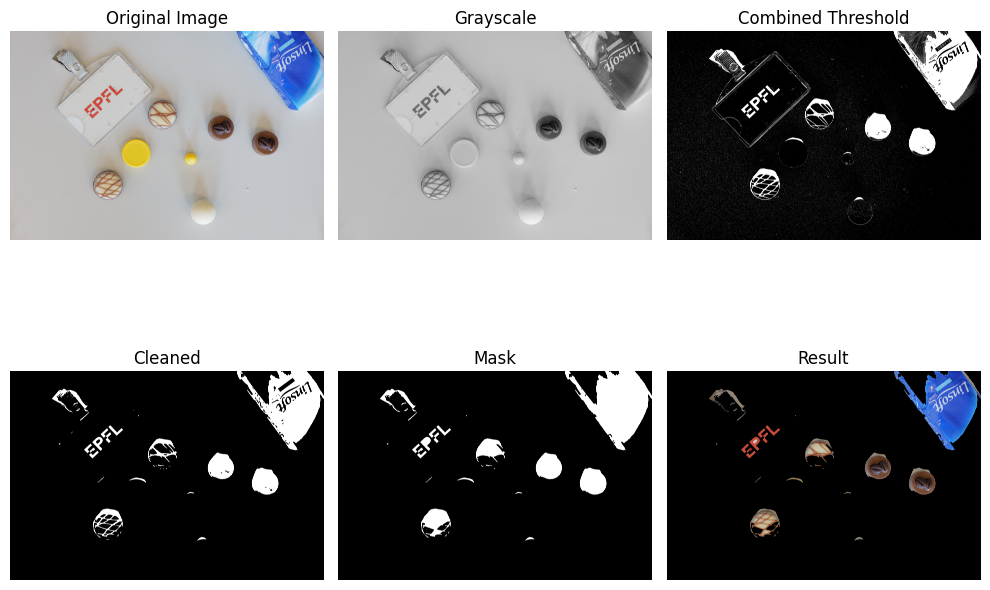

In [64]:
img_path = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/train/L1000817.JPG"
image = cv2.imread(img_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Try adaptive thresholding (works better for varying lighting)
adaptive_thresh = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY_INV, 11, 2)

# Also try Otsu's thresholding
_, otsu_thresh = cv2.threshold(blurred, 0, 255, 
                                cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Combine both thresholds
combined_thresh = cv2.bitwise_or(adaptive_thresh, otsu_thresh)

# Clean up with morphological operations
kernel = np.ones((5, 5), np.uint8)
cleaned = cv2.morphologyEx(combined_thresh, cv2.MORPH_OPEN, kernel, iterations=2)
cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

# Find contours
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create mask
mask = np.zeros_like(gray)

# Filter contours by area to remove small noise
min_area = 200  # Adjust as needed
for contour in contours:
    if cv2.contourArea(contour) > min_area:
        cv2.drawContours(mask, [contour], -1, 255, -1)

# Apply mask to original image
result = image.copy()
result[mask == 0] = [0, 0, 0]  # Set background to black

# Create a figure to display all the processing steps
plt.figure(figsize=(10, 8))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Grayscale image
plt.subplot(2, 3, 2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale')
plt.axis('off')

# Thresholded image
plt.subplot(2, 3, 3)
plt.imshow(combined_thresh, cmap='gray')
plt.title('Combined Threshold')
plt.axis('off')

# Cleaned image
plt.subplot(2, 3, 4)
plt.imshow(cleaned, cmap='gray')
plt.title('Cleaned')
plt.axis('off')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

# Result
plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Result')
plt.axis('off')

plt.tight_layout()
plt.show()

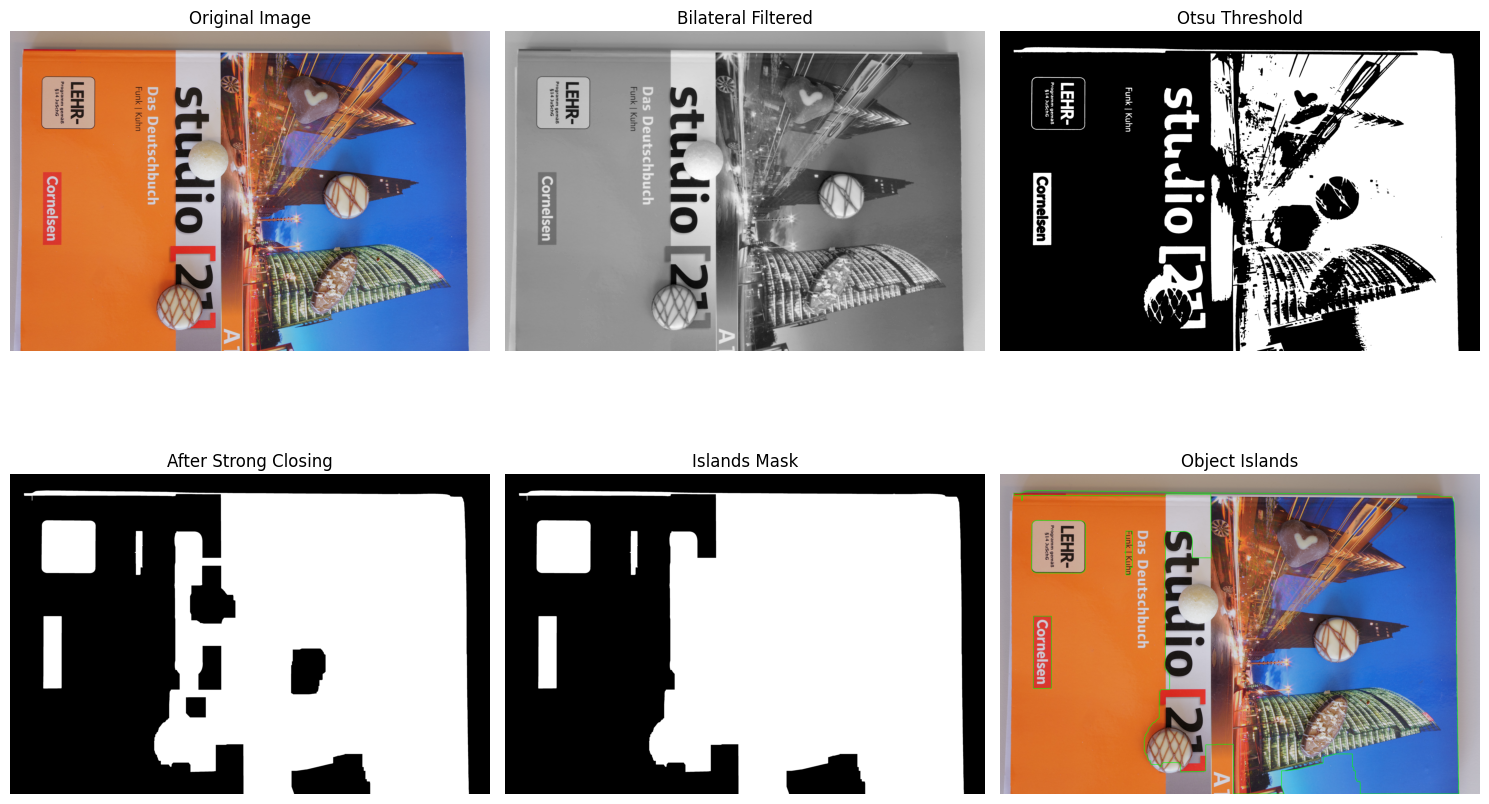

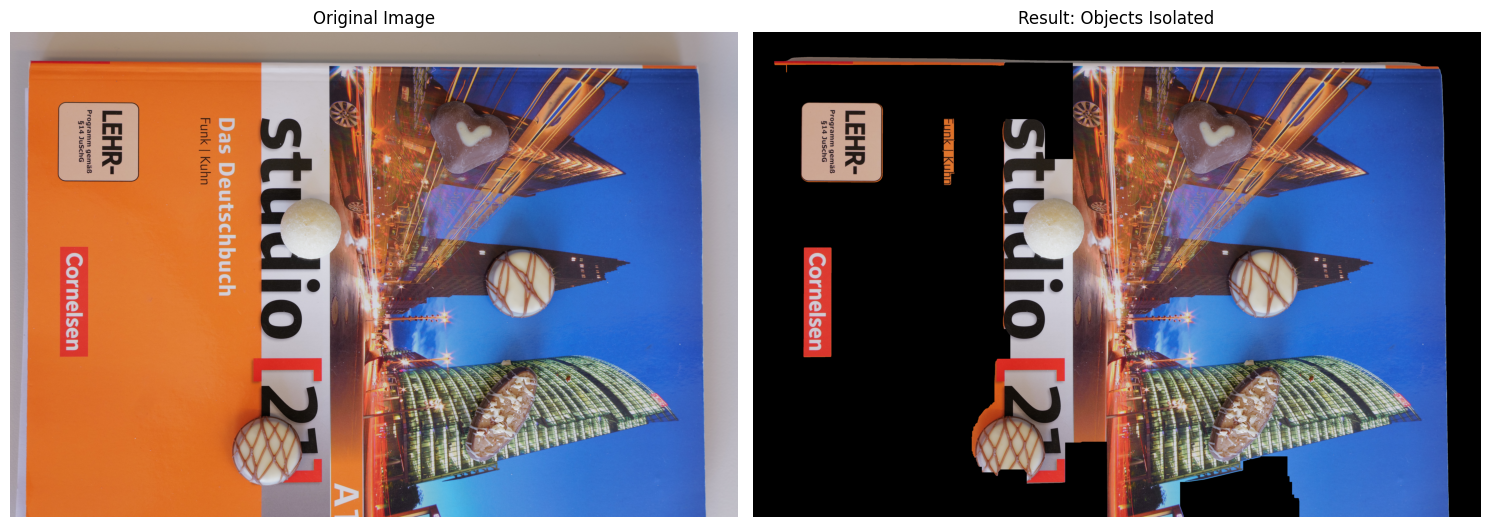

In [82]:
# Load the image
file_name = "L1000859"
img_path = f"/Users/sherwood/Desktop/study/EPFL/IM/project/input_bg/{file_name}.JPG"
image = cv2.imread(img_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply strong bilateral filter (preserves edges better)
filtered = cv2.bilateralFilter(gray, 15, 75, 75)

# Apply Otsu's thresholding
_, thresh = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#Morphology
# kernel_small = np.ones((3, 3), np.uint8)
# kernel_medium = np.ones((7, 7), np.uint8)
# kernel_large = np.ones((15, 15), np.uint8)  # Much larger kernel for aggressive closing
kernel_small = np.ones((3, 3), np.uint8)
kernel_medium = np.ones((7, 7), np.uint8)
kernel_large = np.ones((50, 50), np.uint8)  # Much larger kernel for aggressive closing

# First remove small noise with opening
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_small, iterations=1)

# IMPROVED: Very aggressive closing to ensure complete islands
# This will connect nearby components and fill all holes
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_large, iterations=4)

# Find external contours only (the islands)
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create mask for islands
islands_mask = np.zeros_like(gray)

# Filter contours by area and draw only the valid islands
min_area = 200  # Lower threshold to catch more objects
valid_contours = []

for contour in contours:
    area = cv2.contourArea(contour)
    if area > min_area:
        # This is a valid island
        valid_contours.append(contour)
        
        # Draw filled contour onto our mask
        cv2.drawContours(islands_mask, [contour], -1, 255, -1)

# Create visualization with thick contours
contour_viz = image.copy()
cv2.drawContours(contour_viz, valid_contours, -1, (0, 255, 0), 5)  # Thicker lines

# Apply mask to create result with isolated objects
result = image.copy()
result[islands_mask == 0] = [0, 0, 0]  # Set background to black

# Create a figure to display steps
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Filtered image
plt.subplot(2, 3, 2)
plt.imshow(filtered, cmap='gray')
plt.title('Bilateral Filtered')
plt.axis('off')

# Thresholded image
plt.subplot(2, 3, 3)
plt.imshow(thresh, cmap='gray')
plt.title('Otsu Threshold')
plt.axis('off')

# After strong morphology
plt.subplot(2, 3, 4)
plt.imshow(closed, cmap='gray')
plt.title('After Strong Closing')
plt.axis('off')

# Islands mask
plt.subplot(2, 3, 5)
plt.imshow(islands_mask, cmap='gray')
plt.title('Islands Mask')
plt.axis('off')

# Contour visualization
plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(contour_viz, cv2.COLOR_BGR2RGB))
plt.title('Object Islands')
plt.axis('off')

plt.tight_layout()
plt.show()

# Compare original and result side by side
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Result: Objects Isolated')
plt.axis('off')

plt.tight_layout()
plt.show()